##1. Download the data and glove embeddings

I gdown the data to so you don't have to mount Drive. The pretrained embeddings are download from Stanford's website. I've encountered situations where Collab doesn't close HTTP ports when downloading largish files - hopefully this won't be the case, but if it is, please go Runtime => Disconnect and delete runtime before rerunning.

In [1]:
# %%capture
!gdown 11aG3KiZ4mbrv1rfhbzBW2TgsyJ7kuobi
!mkdir -p /content/product_reviews/
!unzip /content/product_reviews.zip -d /content/product_reviews/
!rm -r /content/product_reviews/__MACOSX
!rm /content/product_reviews.zip
!rm /content/product_reviews/product_reviews/README.txt

!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

Downloading...
From: https://drive.google.com/uc?id=11aG3KiZ4mbrv1rfhbzBW2TgsyJ7kuobi
To: /content/product_reviews.zip
100% 176k/176k [00:00<00:00, 101MB/s]
Archive:  /content/product_reviews.zip
   creating: /content/product_reviews/product_reviews/
  inflating: /content/product_reviews/__MACOSX/._product_reviews  
  inflating: /content/product_reviews/product_reviews/Diaper_Champ.txt  
  inflating: /content/product_reviews/__MACOSX/product_reviews/._Diaper_Champ.txt  
  inflating: /content/product_reviews/product_reviews/norton.txt  
  inflating: /content/product_reviews/__MACOSX/product_reviews/._norton.txt  
  inflating: /content/product_reviews/product_reviews/Hitachi_router.txt  
  inflating: /content/product_reviews/__MACOSX/product_reviews/._Hitachi_router.txt  
  inflating: /content/product_reviews/product_reviews/ipod.txt  
  inflating: /content/product_reviews/__MACOSX/product_reviews/._ipod.txt  
  inflating: /content/product_reviews/product_reviews/Linksys_Router.txt  
  i

##2. Import libs



In [2]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Embedding, Bidirectional
from keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, KFold
import torchtext
tokenizer = torchtext.data.get_tokenizer("basic_english")

##3. Construct dataset



In [3]:
#@title Contraction map and pattern definitions
# from https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/nlp%20proven%20approach/contractions.py
"""
@author: DIP
"""

CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

# re.compile object to help to find document places with contractions
CONTRACTIONS_PATTERN = re.compile(
    "({})".format("|".join(CONTRACTION_MAP.keys())),
    flags=re.IGNORECASE | re.DOTALL,
)

In [4]:
# @title Clean and construct datasets
FOLDER_PATH = "/content/product_reviews/product_reviews"


def expand_contractions(text):
    """
    Expand all contractions in a given string.
    Variable names are explanatory.

    text, str: string to expand contractions in

    Returns:
    expanded_text, str: text with expanded contractions
    and removed apostrophess
    """

    def expand_match(contraction):
        """
        Expand a matched contraction.
        Variable names are explanatory.

        contraction, re.Match object: matched contraction in an str

        Returns:
        expanded_text, str: match with expanded contractions
        """
        # re.Match object, group(0) is the match str
        match = contraction.group(0)
        # in case it's lowercase
        first_char = match[0]
        # find the matching key and value from the map
        expanded_contraction = (
            CONTRACTION_MAP.get(match)
            if CONTRACTION_MAP.get(match)
            else CONTRACTION_MAP.get(match.lower())
        )
        expanded_contraction = first_char + expanded_contraction[1:]
        return expanded_contraction

    expanded_text = CONTRACTIONS_PATTERN.sub(expand_match, text)
    expanded_text = re.sub("'", " ", expanded_text)
    return expanded_text


def remove_long_sequences(x, y, length_threshold):
    """
    Remove sequences longer than length_threshold
    number of tokens from the dataset.

    x, np.array - array of strings to be
    classified
    y, np.array - corresponding labels
    length_threshold, int - sequences with
    tokens more than that are removed

    Returns:
    x, np.array - corresponding array of strings
    y, np.array - corresponding array of labels
    """
    short_indices = np.array(
        [idx for idx, entry in enumerate(x) if len(tokenizer(entry)) < length_threshold]
    )
    return x[short_indices], y[short_indices]


def balance_dataset(x, y):
    """
    Randomly equalize the number of positive
    and negative examples for an unbalanced dataset
    (# positives > # negatives)

    x, np.array - array of strings to be
    classified
    y, np.array - corresponding labels

    Returns:
    x, np.array - corresponding array of strings
    y, np.array - corresponding array of labels
    """
    num_negatives = len(np.where(y == 0)[0])
    negative_indices = np.where(y == 0)[0]
    positive_indices = np.where(y == 1)[0]
    random_positive_pick_indices = np.random.choice(
        positive_indices, size=num_negatives, replace=False
    )
    x = np.append(x[random_positive_pick_indices], x[negative_indices])
    y = np.append(y[random_positive_pick_indices], y[negative_indices])
    return x, y


huge_string = ""  # where we store each .txt string with key as the file name
for file_name in os.listdir(FOLDER_PATH):
    if file_name.endswith(".txt"):
        huge_string += open(
            os.path.join(FOLDER_PATH, file_name), encoding="utf-8"
        ).read()
huge_string = expand_contractions(huge_string)  # expand the contractions - useful for sentiment analysis
unneeded_markers = [
    "[u]",
    "[p]",
    "[s]",
    "[cc]",
    "[cs]",
]  # remove dataset markers which don't help us
for unneeded_marker in unneeded_markers:
    huge_string = huge_string.replace(unneeded_marker, "")
huge_string = huge_string.replace("\n", " ").replace(
    "##", "## "
)  # remove python readin newlines, add a space before new sentence marker
split_by_t = list(
    filter(None, huge_string.split("[t]"))  # remove empty artefacts in the dataset
)  # now have separate (according to readme) reviews, with separate aspects considered with a rating
sentiment_markers = [
    "[-3]",
    "[-2]",
    "[-1]",
    "[+1]",
    "[+2]",
    "[+3]",
]  # actually it's quicker to just use [+ and [- and similar
# [ <RETURNED_VALUE>  <OUTER_LOOP1>  <INNER_LOOP2>  <INNER_LOOP3> ... <OPTIONAL_IF> ]
rated_reviews_cluster_list = [
    split_by_t_element
    for split_by_t_element in split_by_t
    # for sentiment_marker in sentiment_markers
    # if sentiment_marker in split_by_t_element
    if "]##" in split_by_t_element
]  # check if those the entries actually contain a rating
rated_reviews_cluster_string = "".join(
    rated_reviews_cluster_list
)  # merge to string again
all_tokens = tokenizer(rated_reviews_cluster_string)  # easy way to remove extra spaces
sentiment_start_indices = [
    token_idx
    for token_idx in range(len(all_tokens))
    # for sentiment_marker in sentiment_markers
    # if sentiment_marker in all_tokens[token_idx]
    if "]##" in all_tokens[token_idx]
]  # got where the sentiment markers start
# let's merge the sentiment starts which have another marker before them
double_sentiment_start_indices = []
for sentiment_start_index in sentiment_start_indices:
    #     if any(
    #         True
    #         for sentiment_marker in sentiment_markers
    #         if sentiment_marker in all_tokens[sentiment_start_index - 1]
    # ):
    if "]##" in all_tokens[sentiment_start_index - 1]:
        double_sentiment_start_indices.append(sentiment_start_index - 1)
double_sentiment_start_indices = np.array(double_sentiment_start_indices)
# remove the first marker - by robserving the dataset, *only* two positive aspects are mentioned in a row,
# so the first one makes no difference
for counter, double_sentiment_start_index in enumerate(double_sentiment_start_indices):
    double_sentiment_start_index -= counter
    double_sentiment_start_indices -= 1
    all_tokens[double_sentiment_start_index] = (
        all_tokens[double_sentiment_start_index]
        + all_tokens[double_sentiment_start_index + 1]
    )
    del all_tokens[double_sentiment_start_index]
# swap all 3 positive markers for "positivesentimentfollows" and similarly for all 3 negative markers...
for counter, token in enumerate(all_tokens):
    if "]##" in token:
        rating, token_to_insert = token.split("##")
        if "+" in rating:
            all_tokens[counter] = "positivesentimentfollows"
        if "-" in rating:
            all_tokens[counter] = "negativesentimentfollows"
# so now we can delete the ##s...
all_tokens = list(filter(("##").__ne__, all_tokens))
# and the review markers
all_tokens = [token for token in all_tokens if "[+" not in token and "[-" not in token]
positive_reviews = np.array([])
negative_reviews = np.array([])
all_tokens = np.array(all_tokens, dtype=np.str_)  # dtype for TF
positive_start_indices = np.where(all_tokens == "positivesentimentfollows")
negative_start_indices = np.where(all_tokens == "negativesentimentfollows")
all_start_indices = np.sort(np.append(positive_start_indices, negative_start_indices))
all_start_indices = np.append(
    all_start_indices, len(all_tokens)
)  # artificially add last token idx as the new 'start', so we make sure there are no artefacts
# which are leftover from multi-word aspect titles, and we also do not include the sentiment marker strings
for idx in range(len(all_start_indices) - 1):
    if all_start_indices[idx] in positive_start_indices[0]:  # positive
        positive_reviews = np.append(
            positive_reviews,
            " ".join(
                tokenizer(
                    re.sub(
                        r"[^a-zA-z\s]",  # remove all non alphabetic tokens
                        " ",
                        " ".join(
                            all_tokens[
                                all_start_indices[idx] + 1 : all_start_indices[idx + 1]
                            ]
                        ),
                    )
                )
            ),
        )
    elif all_start_indices[idx] in negative_start_indices[0]:  # negative
        negative_reviews = np.append(
            negative_reviews,
            " ".join(
                tokenizer(
                    re.sub(
                        r"[^a-zA-z\s]",
                        " ",
                        " ".join(
                            all_tokens[
                                all_start_indices[idx] + 1 : all_start_indices[idx + 1]
                            ]
                        ),
                    )
                )
            ),
        )
X_full = np.append(positive_reviews, negative_reviews)
# mark positive reviews as + 1 and negative reviews as 0
Y_full = np.append(
    np.ones(len(positive_reviews), dtype=np.int8),
    np.zeros(len(negative_reviews), dtype=np.int8),
)


**Demo**: the dataset can shortened to contain reviews no longer than LENGTH_THRESHOLD tokens, equalized so there is an equal number of positive and negative examplels and can be downloaded a .csv file. If inspecting as a df, be sure to press the magic wand!

In [5]:
LENGTH_THRESHOLD = 100
BALANCE_DATASET = True

X, Y = X_full, Y_full
if LENGTH_THRESHOLD: X, Y = remove_long_sequences(X, Y, LENGTH_THRESHOLD)
if BALANCE_DATASET: X, Y = balance_dataset(X,Y)

df = pd.DataFrame()

df['X'] = X
df['Y'] = Y
df.to_csv('/content/dataset.csv')
from google.colab import files
files.download('dataset.csv') #download as csv for inspection
df

,X,Y
0,and bluetooth does not drain the battery as qu...,1
1,im able to keep my phone on for about a week m...,1
2,if you are looking for a hp plunge router the ...,1
3,the diaper champ does not require special refi...,1
4,the height adjustment works well not perfect,1
...,...,...
1031,you cannot do that with a sony t which i trade...,0
1032,t supports only midi files,0
1033,and also since it is tri band and since it use...,0
1034,so so customer service calls half were efficie...,0


##4. Model and embedding construction, demo
Glove utils from week 2 of the Sequence Models course of the Open AI Deep learning specialization

In [6]:
#@title Model and embedings utils
def read_glove_vecs(glove_file_path):
    """
    Process the Glove embedding file.

    glove_file_path, str - path to the embedding .txt

    Returns:
    word_to_index, dict - mapping from words to their indices in the vocabulary
    index_to_word, dict - mapping from indices to their corresponding words in the vocabulary
    word_to_vec_map, dict - mapping words to their GloVe vector representation
    """
    with open(glove_file_path, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

def softmax(x):
    """Compute softmax values for each sets of scores in x vector."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def convert_to_one_hot(Y, C):
    """Convert an int label Y to one-hot representation for C classes."""
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`
    
    X -- array of sentences (strings), of shape (m,)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    m = X.shape[0] # number of training examples
    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros((m, max_len))
    for i in range(m):                               # loop over training examples
        # Convert the ith training sentence in lower case and split is into words, get a list
        sentence_words = X[i].lower().split()
        # Initialize j to 0
        j = 0
        # Loop over the words of sentence_words
        doubles = 0
        for w in sentence_words:
            # if w exists in the word_to_index dictionary
            if w in word_to_index:
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                try: #
                  X_indices[i, j] = word_to_index[w]
                  j =  j + 1
                except IndexError:
                  doubles += 1
    return X_indices

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    vocab_size = len(word_to_index) + 1              # adding 1 to fit Keras embedding (requirement)
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]    # define dimensionality of GloVe word vectors
    # Initialize the embedding matrix as a numpy array of zeros
    emb_matrix = np.zeros((vocab_size, emb_dim))
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(input_dim = vocab_size, output_dim = emb_dim, trainable = False)
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,))     
    # Set the weights of the embedding layer to the embedding matrix, it's now pretrained
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer

def Binary_RNN(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph
    # of shape input_shape and dtype 'int32' (indices are integers).
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)
    # Propagate the embeddings through bid. LSTM layer with units-dimensional hidden state, return a batch of sequences
    X = Bidirectional(LSTM(units = 128, return_sequences = True))(embeddings)
    # dropout for regularisation
    X = Dropout(rate = 0.5)(X)
    # Propagate X trough another bid. LSTM layer with units-dimensional hidden state
    # The returned output is a single hidden state, not a batch of sequences
    X = Bidirectional(LSTM(units = 128, return_sequences = False))(X)
    X = Dropout(rate = 0.5)(X)
    # Propagate X through a Dense layer with 2 units
    X = Dense(units = 2)(X)
    # Add a softmax activation
    X = Activation(activation = 'softmax')(X)  
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs = sentence_indices, outputs = X)
    return model

For the model summary to load up, I load the smallest (50D) vectors. For the experiments, there is an option to pick the dimentionality...

In [7]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/glove.6B.50d.txt') 
maxLen = len(max(X, key=len).split())
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][1] =", embedding_layer.get_weights()[0][1][1])
print("Input_dim", embedding_layer.input_dim)
print("Output_dim",embedding_layer.output_dim)

model = Binary_RNN((maxLen,), word_to_vec_map, word_to_index)
model.summary()

weights[0][1][1] = 0.39031
Input_dim 400001
Output_dim 50
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 90)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 90, 50)            20000050  
                                                                 
 bidirectional (Bidirectiona  (None, 90, 256)          183296    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dr

... and, of course, 300 is likely to perform the best. Should load up in +- 20 secs.

In [8]:
GLOVE_DIMENSIONALITY = 300
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(
    "/content/glove.6B." + str(GLOVE_DIMENSIONALITY) + "d.txt"
)

(Hopefully) a quick demo:

Epoch 1/4000
10/10 [==============================] - 10s 496ms/step - loss: 0.6840 - accuracy: 0.5883 - val_loss: 0.6612 - val_accuracy: 0.6564
Epoch 2/4000
10/10 [==============================] - 3s 327ms/step - loss: 0.6711 - accuracy: 0.6098 - val_loss: 0.6512 - val_accuracy: 0.6564
Epoch 3/4000
10/10 [==============================] - 3s 331ms/step - loss: 0.6664 - accuracy: 0.6115 - val_loss: 0.6471 - val_accuracy: 0.6564
Epoch 4/4000
10/10 [==============================] - 3s 327ms/step - loss: 0.6642 - accuracy: 0.6115 - val_loss: 0.6439 - val_accuracy: 0.6564
Epoch 5/4000
10/10 [==============================] - 3s 331ms/step - loss: 0.6604 - accuracy: 0.6124 - val_loss: 0.6384 - val_accuracy: 0.6564
Epoch 6/4000
10/10 [==============================] - 3s 332ms/step - loss: 0.6526 - accuracy: 0.6133 - val_loss: 0.6329 - val_accuracy: 0.6564
Epoch 7/4000
10/10 [==============================] - 3s 332ms/step - loss: 0.6472 - accuracy: 0.6133 - val_loss: 0.6225 - val_accuracy

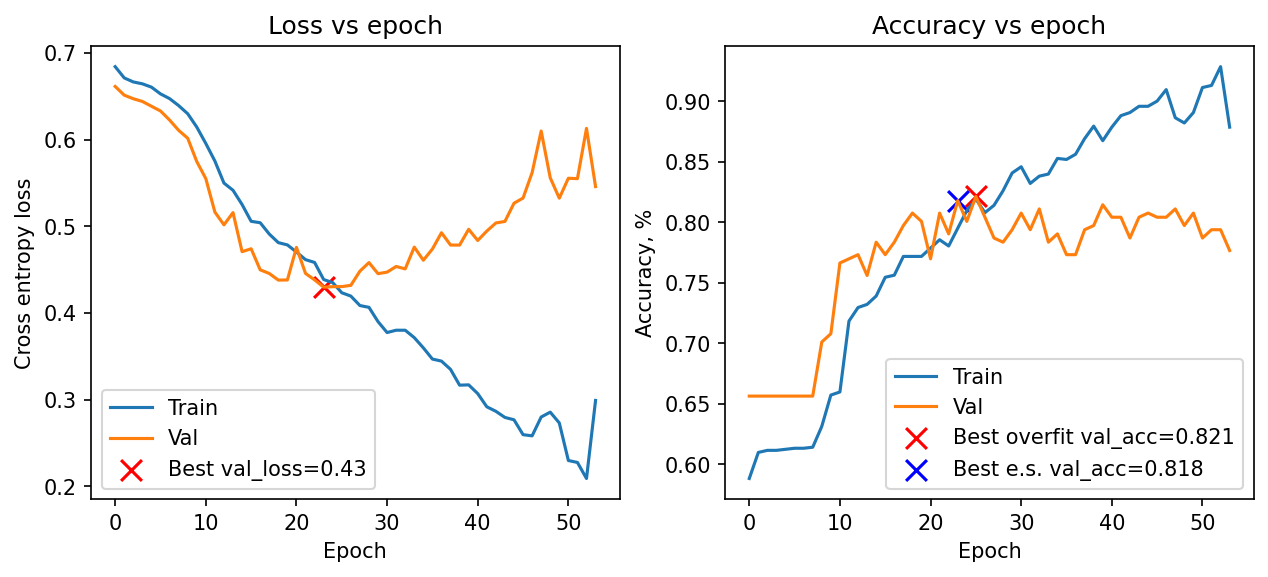

In [45]:
LENGTH_THRESHOLD = 9999 #tokens shorter than what # of words to include
BALANCE_DATASET = False #equalize the number of training and testing examples
LR = 10e-5
BATCH_SIZE = 128
PATIENCE = 30 # after how many epochs when the val loss has not improved to halt training

X, Y = X_full, Y_full
if LENGTH_THRESHOLD:
    X, Y = remove_long_sequences(X, Y, LENGTH_THRESHOLD)
if BALANCE_DATASET:
    X, Y = balance_dataset(X, Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
maxLen = len(max(X_train, key=len).split()) #length of the longest sequence to define the number of cells

X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len=maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C=2)
Y_test_oh = convert_to_one_hot(Y_test, C=2)

opt = Adam(learning_rate=LR)

model = Binary_RNN((maxLen,), word_to_vec_map, word_to_index)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# early stopping Keras callback
es = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=PATIENCE,
    restore_best_weights=True,
)

history = model.fit(
    X_train_indices,
    Y_train_oh,
    validation_data=(X_test_indices, Y_test_oh),
    epochs=4000,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=[es],
    verbose=1,
)

fig = plt.figure(figsize=(10, 4), dpi=150)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(history.history["loss"], label="Train")
ax1.plot(history.history["val_loss"], label="Val")
ax1.scatter(
    np.arange(0, len(history.history["val_loss"]))[
        np.argmin(history.history["val_loss"])
    ],
    np.min(history.history["val_loss"]),
    marker="x",
    label=r"Best val_loss=" + str(np.round(np.min(history.history["val_loss"]), 2)),
    c="r",
    s=100,
    alpha=1,
)
ax1.set_title("Loss vs epoch")
ax1.set_xlabel(r"Epoch")
ax1.legend(loc="best")
ax1.set_ylabel("Cross entropy loss")
ax2.plot(history.history["accuracy"], label="Train")
ax2.plot(history.history["val_accuracy"], label="Val")
ax2.scatter(
    np.arange(0, len(history.history["val_accuracy"]))[
        np.argmax(history.history["val_accuracy"])
    ],
    np.max(history.history["val_accuracy"]),
    marker="x",
    label=r"Best overfit val_acc=" + str(np.round(np.max(history.history["val_accuracy"]), 3)),
    c="r",
    s=100,
    alpha=1,
)
ax2.scatter(
    np.arange(0, len(history.history["val_accuracy"]))[
        np.argmin(history.history["val_loss"])
    ],
    (history.history["val_accuracy"])[np.argmin(history.history["val_loss"])],
    marker="x",
    label=r"Best e.s. val_acc="
    + str(
        np.round(
            (history.history["val_accuracy"])[np.argmin(history.history["val_loss"])], 3
        )
    ),
    c="b",
    s=100,
    alpha=1,
)
ax2.set_title("Accuracy vs epoch")
ax2.set_xlabel(r"Epoch")
ax2.legend(loc="best")
ax2.set_ylabel("Accuracy, %")

plt.legend()
plt.show()


In [54]:
print(((model.predict(sentences_to_indices(np.array(['I loved this module']), word_to_index, maxLen)))))

1/1 [==============================] - 0s 51ms/step
[[0.02945199 0.97054803]]


In [55]:
print(((model.predict(sentences_to_indices(np.array(['bad terrible awful']), word_to_index, maxLen)))))

1/1 [==============================] - 0s 51ms/step
[[0.5576351  0.44236487]]


In [69]:
print(((model.predict(sentences_to_indices(np.array(["thistokenisdefinitelynotpartofthedictionary"]), word_to_index, maxLen)))))

1/1 [==============================] - 0s 52ms/step
[[0.41305566 0.58694434]]


##5. CV experiment

Identical setup as in demo, only with CV.


In [9]:
GLOVE_DIMENSIONALITY = 300
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(
    "/content/glove.6B." + str(GLOVE_DIMENSIONALITY) + "d.txt"
)
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

With balancing:

In [10]:
N_SPLITS = 5
LENGTH_THRESHOLD = 9999
BALANCE_DATASET = True
LR = 10e-5
PATIENCE = 20

best_early_stopping_accuracies = []
best_overfit_accuracies = []

X, Y = X_full, Y_full
if LENGTH_THRESHOLD:
    X, Y = remove_long_sequences(X, Y, LENGTH_THRESHOLD)
if BALANCE_DATASET:
    X, Y = balance_dataset(X, Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((Y_train, Y_test), axis=0)

kfold = KFold(n_splits=N_SPLITS, shuffle=True)
opt = Adam(learning_rate=LR)
es = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=PATIENCE,
    restore_best_weights=True,
)

for counter, data in tqdm(enumerate(kfold.split(inputs, targets))):
    print("\n##### Training and evaluation in split ", str(counter + 1), " #####\n")
    train, test = data
    X_train, X_test, Y_train, Y_test = (
        inputs[train],
        inputs[test],
        targets[train],
        targets[test],
    )
    maxLen = len(max(X_train, key=len).split())

    X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
    X_test_indices = sentences_to_indices(X_test, word_to_index, max_len=maxLen)
    Y_train_oh = convert_to_one_hot(Y_train, C=2)
    Y_test_oh = convert_to_one_hot(Y_test, C=2)

    model = Binary_RNN((maxLen,), word_to_vec_map, word_to_index)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

    history = model.fit(
        X_train_indices,
        Y_train_oh,
        validation_data=(X_test_indices, Y_test_oh),
        epochs=4000,
        batch_size=256,
        shuffle=True,
        callbacks=[es],
        verbose=2,
    )

    best_early_stopping_accuracies.append(
        (history.history["val_accuracy"])[np.argmin(history.history["val_loss"])]
    )
    best_overfit_accuracies.append(np.max(history.history["val_accuracy"]))

    print("\n")
print("\n\n################## RESULTS ##################")
print(
    "With overfitting the train set, the accuracy is ",
    str(np.round((np.mean(best_overfit_accuracies)), 3)),
    "±",
    str(np.round(np.std(best_overfit_accuracies), 3)),
)
print(
    "With early stopping, the accuracy is ",
    str(np.round((np.mean(best_early_stopping_accuracies)), 3)),
    "±",
    str(np.round(np.std(best_early_stopping_accuracies), 3)),
)


0it [00:00, ?it/s]


##### Training and evaluation in split  1  #####

Epoch 1/4000
4/4 - 14s - loss: 0.6914 - accuracy: 0.5255 - val_loss: 0.6913 - val_accuracy: 0.5249 - 14s/epoch - 4s/step
Epoch 2/4000
4/4 - 2s - loss: 0.6927 - accuracy: 0.5289 - val_loss: 0.6889 - val_accuracy: 0.5294 - 2s/epoch - 512ms/step
Epoch 3/4000
4/4 - 2s - loss: 0.6898 - accuracy: 0.5392 - val_loss: 0.6865 - val_accuracy: 0.5611 - 2s/epoch - 514ms/step
Epoch 4/4000
4/4 - 2s - loss: 0.6859 - accuracy: 0.5619 - val_loss: 0.6837 - val_accuracy: 0.5973 - 2s/epoch - 509ms/step
Epoch 5/4000
4/4 - 2s - loss: 0.6821 - accuracy: 0.6027 - val_loss: 0.6809 - val_accuracy: 0.6471 - 2s/epoch - 518ms/step
Epoch 6/4000
4/4 - 2s - loss: 0.6793 - accuracy: 0.6266 - val_loss: 0.6778 - val_accuracy: 0.6471 - 2s/epoch - 513ms/step
Epoch 7/4000
4/4 - 2s - loss: 0.6757 - accuracy: 0.6334 - val_loss: 0.6741 - val_accuracy: 0.6742 - 2s/epoch - 521ms/step
Epoch 8/4000
4/4 - 2s - loss: 0.6742 - accuracy: 0.6390 - val_loss: 0.6696 - val_accuracy: 0.669

Without balancing:

In [11]:
N_SPLITS = 5
LENGTH_THRESHOLD = 9999
BALANCE_DATASET = False
LR = 10e-5
PATIENCE = 20

best_early_stopping_accuracies = []
best_overfit_accuracies = []

X, Y = X_full, Y_full
if LENGTH_THRESHOLD:
    X, Y = remove_long_sequences(X, Y, LENGTH_THRESHOLD)
if BALANCE_DATASET:
    X, Y = balance_dataset(X, Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((Y_train, Y_test), axis=0)

kfold = KFold(n_splits=N_SPLITS, shuffle=True)
opt = Adam(learning_rate=LR)
es = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=PATIENCE,
    restore_best_weights=True,
)

for counter, data in tqdm(enumerate(kfold.split(inputs, targets))):
    print("\n##### Training and evaluation in split ", str(counter + 1), " #####\n")
    train, test = data
    X_train, X_test, Y_train, Y_test = (
        inputs[train],
        inputs[test],
        targets[train],
        targets[test],
    )
    maxLen = len(max(X_train, key=len).split())

    X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
    X_test_indices = sentences_to_indices(X_test, word_to_index, max_len=maxLen)
    Y_train_oh = convert_to_one_hot(Y_train, C=2)
    Y_test_oh = convert_to_one_hot(Y_test, C=2)

    model = Binary_RNN((maxLen,), word_to_vec_map, word_to_index)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

    history = model.fit(
        X_train_indices,
        Y_train_oh,
        validation_data=(X_test_indices, Y_test_oh),
        epochs=4000,
        batch_size=256,
        shuffle=True,
        callbacks=[es],
        verbose=2,
    )

    best_early_stopping_accuracies.append(
        (history.history["val_accuracy"])[np.argmin(history.history["val_loss"])]
    )
    best_overfit_accuracies.append(np.max(history.history["val_accuracy"]))

    print("\n")
print("\n\n################## RESULTS ##################")
print(
    "With overfitting the train set, the accuracy is ",
    str(np.round((np.mean(best_overfit_accuracies)), 3)),
    "±",
    str(np.round(np.std(best_overfit_accuracies), 3)),
)
print(
    "With early stopping, the accuracy is ",
    str(np.round((np.mean(best_early_stopping_accuracies)), 3)),
    "±",
    str(np.round(np.std(best_early_stopping_accuracies), 3)),
)


0it [00:00, ?it/s]


##### Training and evaluation in split  1  #####

Epoch 1/4000
5/5 - 9s - loss: 0.6971 - accuracy: 0.4875 - val_loss: 0.6870 - val_accuracy: 0.5808 - 9s/epoch - 2s/step
Epoch 2/4000
5/5 - 3s - loss: 0.6757 - accuracy: 0.6167 - val_loss: 0.6844 - val_accuracy: 0.5808 - 3s/epoch - 523ms/step
Epoch 3/4000
5/5 - 2s - loss: 0.6690 - accuracy: 0.6279 - val_loss: 0.6860 - val_accuracy: 0.5808 - 2s/epoch - 462ms/step
Epoch 4/4000
5/5 - 2s - loss: 0.6619 - accuracy: 0.6305 - val_loss: 0.6876 - val_accuracy: 0.5808 - 2s/epoch - 459ms/step
Epoch 5/4000
5/5 - 2s - loss: 0.6611 - accuracy: 0.6305 - val_loss: 0.6878 - val_accuracy: 0.5808 - 2s/epoch - 467ms/step
Epoch 6/4000
5/5 - 2s - loss: 0.6569 - accuracy: 0.6305 - val_loss: 0.6861 - val_accuracy: 0.5808 - 2s/epoch - 465ms/step
Epoch 7/4000
5/5 - 3s - loss: 0.6572 - accuracy: 0.6305 - val_loss: 0.6818 - val_accuracy: 0.5808 - 3s/epoch - 534ms/step
Epoch 8/4000
5/5 - 3s - loss: 0.6531 - accuracy: 0.6305 - val_loss: 0.6768 - val_accuracy: 0.5808 